In [1]:
import sys
if not '../..' in sys.path:
    sys.path.append('../..')
    sys.path.append('..')
from analysis import collection, analysis, emg, plot, model
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import patches, lines
from pathlib import Path
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from joblib import dump, load
from analysis.offsets import offsets
import pickle

mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update({'axes.labelsize': 16})
mpl.rcParams.update({'figure.figsize': (16*0.8,9*0.8)})
mpl.rcParams.update({'axes.facecolor': "white"})
mpl.rcParams.update({'lines.marker': "+"})
mpl.rcParams.update({'lines.linestyle': ""})
mpl.rcParams.update({"axes.spines.left":   True})
mpl.rcParams.update({"axes.spines.bottom": True})
mpl.rcParams.update({"axes.spines.top":    False})
mpl.rcParams.update({"axes.spines.right":  False})

image_path = Path("/Users/spencer/phd/phd/images/more_results/nullspace/")

%matplotlib inline

Our hypothesis here is that if we optimize to find solutions in emg space which reach a chosen target while also minimizing a chosen function, e.g. distance of that solution to a statistical model, we can compare the distances between each of these solutions to the solutions subjects actually found in the task to suggest what subjects were optimizing for across learning.

## load data

this filtered data is NOT log-transformed

In [2]:
with open('../olympics_subjects.pkl', 'rb') as handle:
    subjects = pickle.load(handle)
print(len(subjects))

subject_calibration_stacks = np.load("../subject_filtered_calibration_stacks.npy")
print(subject_calibration_stacks.shape)

subject_movement_stacks = np.load("../subject_filtered_movement_stacks.npy")
print(subject_movement_stacks.shape)

46
(46, 2, 32, 64, 2400)
(46, 2, 14, 64, 2000)


### experimental mixture model distances

In [3]:
# def mixture_likelihood(model, x):
#     sum = 0
#     for mu, W, weight in zip(model.means_, model.covariances_, model.weights_):
#         logN = -1*(((x-mu).T @ np.linalg.inv(W) @ (x-mu)).reshape(-1)[0] + np.log(np.linalg.det(W)))
#         logw = np.log(weight)
#         sum += np.exp(logN + logw)
#     return sum

# def tipping_metric(model, xi, xj):
#     # generalization of the mahalanobis distance
#     # using a heuristic metric G(x) = sum_1^K { p(k|x) C_k^-1}
#     # a component-probability-weighted average of each mixture component's
#     # metric (inverse convariance)
#     # cf. "DERIVING CLUSTER ANALYTIC DISTANCE
#     #      FUNCTIONS FROM GAUSSIAN MIXTURE MODELS" 1999, Mike Tipping
#     means = model.means_
#     weights = model.weights_
#     Cinvs = [np.linalg.inv(C) for C in model.covariances_]
#     def integral(k):
#         v = (xi - xj).reshape(-1,1)
#         u = (means[k].reshape(-1,1) - xj).reshape(-1,1)
#         b2 = ((v.T @ Cinvs[k] @ v).reshape(-1)[0])**-1
#         a = b2*((v.T @ Cinvs[k] @ u).reshape(-1)[0])
#         e1 = (1 - a) / np.sqrt(2*b2)
#         e2 = (-a) / np.sqrt(2*b2)
#         Z = (u.T @ Cinvs[k] @ u).reshape(-1)[0] - b2*((v.T @ Cinvs[k] @ u).reshape(-1)[0]**2)
#         return np.sqrt(np.pi*b2*0.5)*(np.exp(-Z*0.5))*(sp.special.erf(e1) - sp.special.erf(e2))
#     integrals = [integral(k) for k in range(len(means))]
#     numerator = sum([np.linalg.inv(C_k)*pi_k*integral_k for C_k, pi_k, integral_k in zip(Cinvs,weights,integrals)])
#     denominator = sum([pi_k*integral_k for pi_k,integral_k in zip(weights,integrals)])
#     G = numerator / denominator
#     return G

# def tipping_distance(G, xi, xj):
#     d = xi - xj
#     return (d.T @ G @ d).reshape(-1)[0]
    
# def min_tipping_distance(model, x):
#     min_d = np.inf
#     min_G = None
#     for u,w in zip(model.means_,model.weights_):
#         G = tipping_metric(model,x,u.reshape(-1,1))
#         d = tipping_distance(G,x,u.reshape(-1,1))*w
#         if d < min_d:
#             min_d = d
#             min_G = G
#         return min_d, min_G

# def min_model_distance(model,x):
#     def quadratic(A,x):
#         return (x.T @ A @ x).reshape(-1)[0]
#     Cinvs = [np.linalg.inv(C) for C in model.covariances_]
#     return np.mean([quadratic(Cinvs[k],x-model.means_[k].reshape(-1,1))*model.weights_[k] for k in range(len(Cinvs))])


## optimization functions for scipy.optimize

In [4]:
from scipy.optimize import minimize

# https://people.duke.edu/~ccc14/sta-663-2018/notebooks/S09H_Constrained_Optimization.html

def lagrange_fit(W,mu,D,x,e0=None,nonnegative=False,viz=False):
    traj = []

    def f(e, W, mu):
        traj.append(e)
        return ((e - mu).T @ W @ (e - mu)).reshape(-1)[0]
        # return (e.T) @ (W + np.eye(64)) @ (e) - + mu.T @ mu
        # return e.T @ W @ e + (e - mu).T @ (e - mu)
    
    def target_constraint(e):
        return D @ e - x
    
    def nonnegative_constraint(e):
        return e
    
    if nonnegative:
        cons = ({'type': 'eq', 'fun': target_constraint},
                {'type': 'ineq', 'fun': nonnegative_constraint})
    else:
        cons = ({'type': 'eq', 'fun': target_constraint})
                
    if e0 is None:
        e0 = np.zeros(shape=(64,))
    
    res = minimize(f, e0, constraints=cons, args=(W,mu))
    
    if viz:
        return res.x, traj
    else:
        return res.x


def lagrange_fit_model_no_log(model,D,x,e0=None,nonnegative=False,viz=False):
    traj = []

    def f(e, model):
        traj.append(e)
        return -model.score(e.reshape(1,-1))
    
    def target_constraint(e):
        return D @ e - x
    
    def nonnegative_constraint(e):
        return e

    if nonnegative:
        cons = ({'type': 'eq', 'fun': target_constraint},
                {'type': 'ineq', 'fun': nonnegative_constraint})
    else:
        cons = ({'type': 'eq', 'fun': target_constraint})
    
    if e0 is None:
        e0 = np.zeros(shape=(64,))
    
    res = minimize(f, e0, constraints=cons, args=(model))
    
    if viz:
        return res.x, traj
    else:
        return res.x


def lagrange_fit_model(model,D,x,e0=None,nonnegative=False):

    def f(e, model):
        return -model.score(np.log(e.reshape(1,-1)))
    
    def target_constraint(e):
        return D @ e - x
    
    def nonnegative_constraint(e):
        return e

    if nonnegative:
        cons = ({'type': 'eq', 'fun': target_constraint},
                {'type': 'ineq', 'fun': nonnegative_constraint})
    else:
        cons = ({'type': 'eq', 'fun': target_constraint})
    
    if e0 is None:
        e0 = np.zeros(shape=(64,)) + 0.01

    res = minimize(f, e0, constraints=cons, args=(model), bounds=[(1e-9,20.0) for _ in range(e0.shape[0])], options={"disp":False})
    
    return res.x

## visualize optimization in 2D

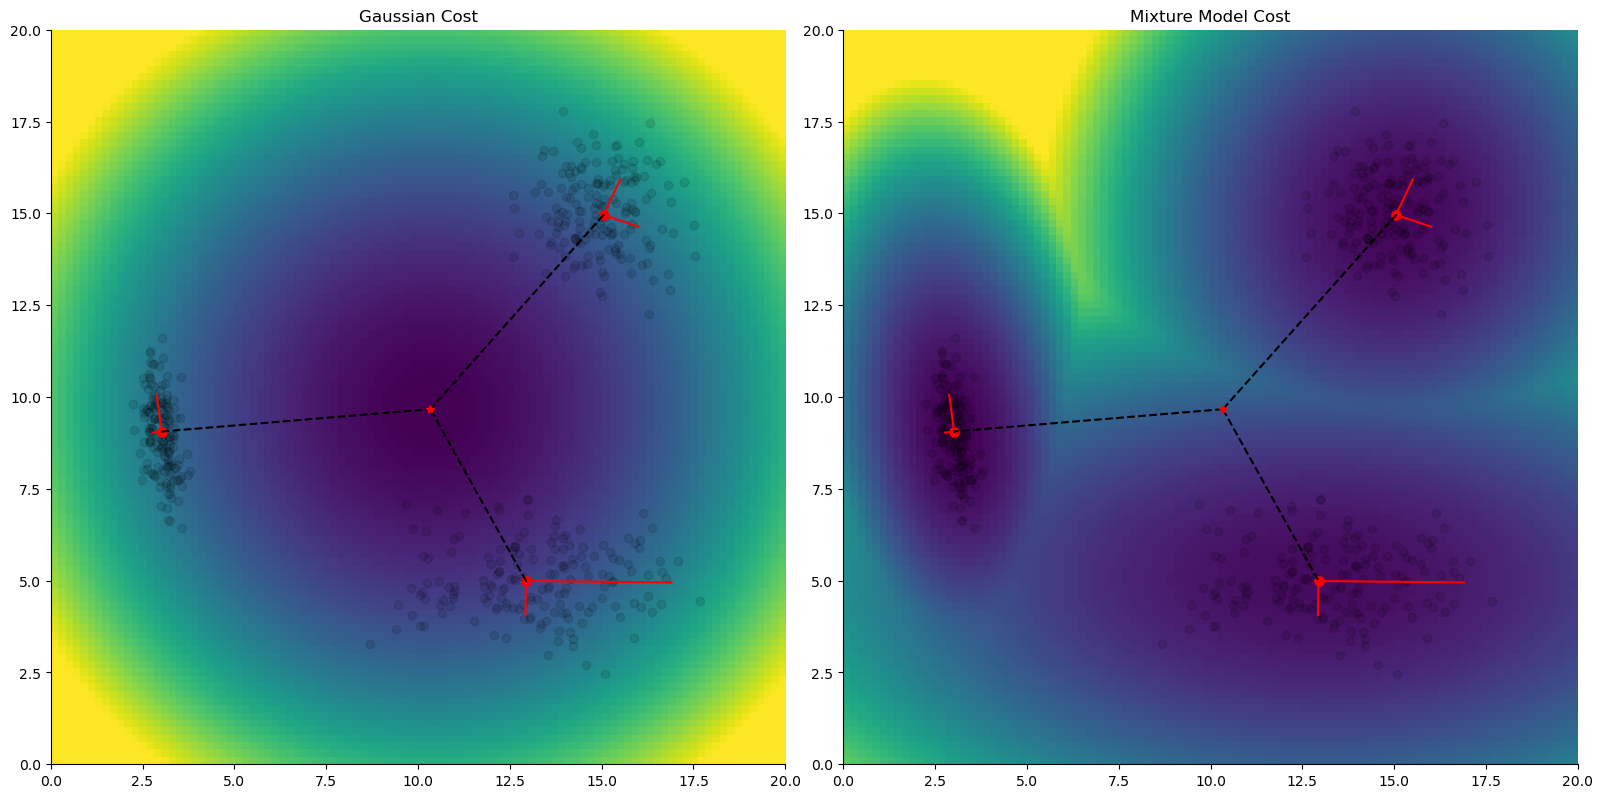

In [192]:
# three gaussians
g1 = np.random.multivariate_normal(mean=[3,9,0],cov=[[.1,-.1,0],[-.1,1,0],[0,0,1]],size=(500))
g2 = np.random.multivariate_normal(mean=[15,15,0],cov=[[1.,0,0],[0,1,0],[0,0,1]],size=(500))
g3 = np.random.multivariate_normal(mean=[13,5,0],cov=[[4,0,0],[0,1,0],[0,0,1]],size=(500))
samples = np.concatenate([g1,g2,g3])

model = BayesianGaussianMixture(n_components=3)
model.fit(samples)
evals, evecs = np.linalg.eig(model.covariances_)

grand_mean = np.mean(model.means_,axis=0)
# 2x3 -- kills  the "z" component!
decoder = np.array([[1,0,0],[0,1,0]]).reshape(2,3)


# plot the means
cost_function_fig, axes = plt.subplots(1,2,figsize=(16,16))
cost_function_fig.tight_layout()

for ax in axes:
    ax.plot(samples[::3,0],samples[::3,1],'ko',alpha=0.1)
    for mi, mean in enumerate(model.means_):
        ax.plot(mean[0],mean[1],"ro",alpha=1,markersize=20*model.weights_[mi])
        ax.plot([mean[0], mean[0] + evals[mi][0]*evecs[mi][0][0]], [mean[1], mean[1] + evals[mi][0]*evecs[mi][1][0]],"r-")
        ax.plot([mean[0], mean[0] + evals[mi][1]*evecs[mi][0][1]], [mean[1], mean[1] + evals[mi][1]*evecs[mi][1][1]],"r-")
    ax.set_aspect("equal")
    # ax.set_xlim([0,20])
    # ax.set_ylim([0,20])


ax = axes[0]
ax.set_title("Gaussian Cost")
# fit the gaussian version
W = np.eye(3)
for m in model.means_:
    # W, mu, d, x, e0
    e0 = np.array([m[0],m[1],0])
    _, traj = lagrange_fit(W, grand_mean, decoder, grand_mean[:2].reshape(-1), e0.reshape(-1), viz=True)
    traj = np.array(traj).T
    ax.plot(traj[0],traj[1],"k--")

distances = np.zeros(shape=(N,N))
xmin, xmax, ymin, ymax = 0,20,0,20
for xi, x in enumerate(np.linspace(xmin,xmax,N)):
    for yi, y in enumerate(np.linspace(ymin,ymax,N)):
        e = np.array([x,y])
        # only the 2D first two components of the distance!
        distances[xi,yi] = ((e - grand_mean[:2]).T @ np.eye(2) @ (e - grand_mean[:2])).reshape(-1)[0]
ax.imshow(distances.T, origin='lower', extent=[xmin, xmax, ymin, ymax], vmax=150)
ax.plot(grand_mean[0],grand_mean[1],"r*")


ax = axes[1]
ax.set_title("Mixture Model Cost")
for m in model.means_:
    # _ _ target, startpoint
    e0 = np.array([grand_mean[0],grand_mean[1],100])
    _, traj = lagrange_fit_model_no_log(model, decoder, m[:2], e0, viz=True)
    traj = np.array(traj).T
    ax.plot(traj[0],traj[1],"k--")

N = 100
distances = np.zeros(shape=(N,N))
xmin, xmax, ymin, ymax = 0,20,0,20
for xi, x in enumerate(np.linspace(xmin,xmax,N)):
    for yi, y in enumerate(np.linspace(ymin,ymax,N)):
        distances[xi,yi] = -model.score(np.array([x,y,0]).reshape(1,-1))
ax.imshow(distances.T, origin='lower', extent=[xmin, xmax, ymin, ymax], vmax=50)

ax.plot(grand_mean[0],grand_mean[1],"r*")

In [193]:
plot.save_figure(cost_function_fig, "example_cost_functions",image_path)

Figure saved to /Users/spencer/phd/phd/images/more_results/nullspace/example_cost_functions.pdf


# get hit ends for all subjects

In [13]:
NUM_ENDPOINTS = 3
hit_ends = np.zeros(shape=(46,45,12,64))
hit_ends[:] = np.nan
for subject_idx, subject in enumerate(subjects):
    target_counter = np.zeros(shape=(12),dtype=int)
    for session in list(subject.tasks["center_hold"].sorted_sessions()):
        for trial in session.sorted_trials():
            if trial.outcome == "Hit":
                hit_end = np.mean(trial.get_filtered_emg()[-NUM_ENDPOINTS:,:], axis=0)
                hit_ends[subject_idx,target_counter[trial.target_number-1],trial.target_number-1] = hit_end
                target_counter[trial.target_number-1] += 1

hit_end_means = np.nanmean(hit_ends, axis=(1))
print(hit_ends.shape, hit_end_means.shape)

(46, 45, 12, 64) (46, 12, 64)


### visualize hit ends, prior means, model means for one subject

In [14]:
def compute_movement_cov(subject_idx):
    calibration = analysis.remove_nan_rows(subject_calibration_stacks[subject_idx].transpose(0,1,3,2).reshape(-1,64))
    return np.cov(calibration.T)

def compute_movement_mean(subject_idx):
    calibration = analysis.remove_nan_rows(subject_calibration_stacks[subject_idx].transpose(0,1,3,2).reshape(-1,64))
    return np.nanmean(calibration.T,axis=1)

def compute_calibration_cov(subject_idx):
    movement = analysis.remove_nan_rows(subject_movement_stacks[subject_idx].transpose(0,1,3,2).reshape(-1,64))
    return np.cov(movement.T)

def compute_calibration_mean(subject_idx):
    movement = analysis.remove_nan_rows(subject_movement_stacks[subject_idx].transpose(0,1,3,2).reshape(-1,64))
    return np.nanmean(movement.T,axis=1)

Text(0, 0.5, 'EMG Activity')

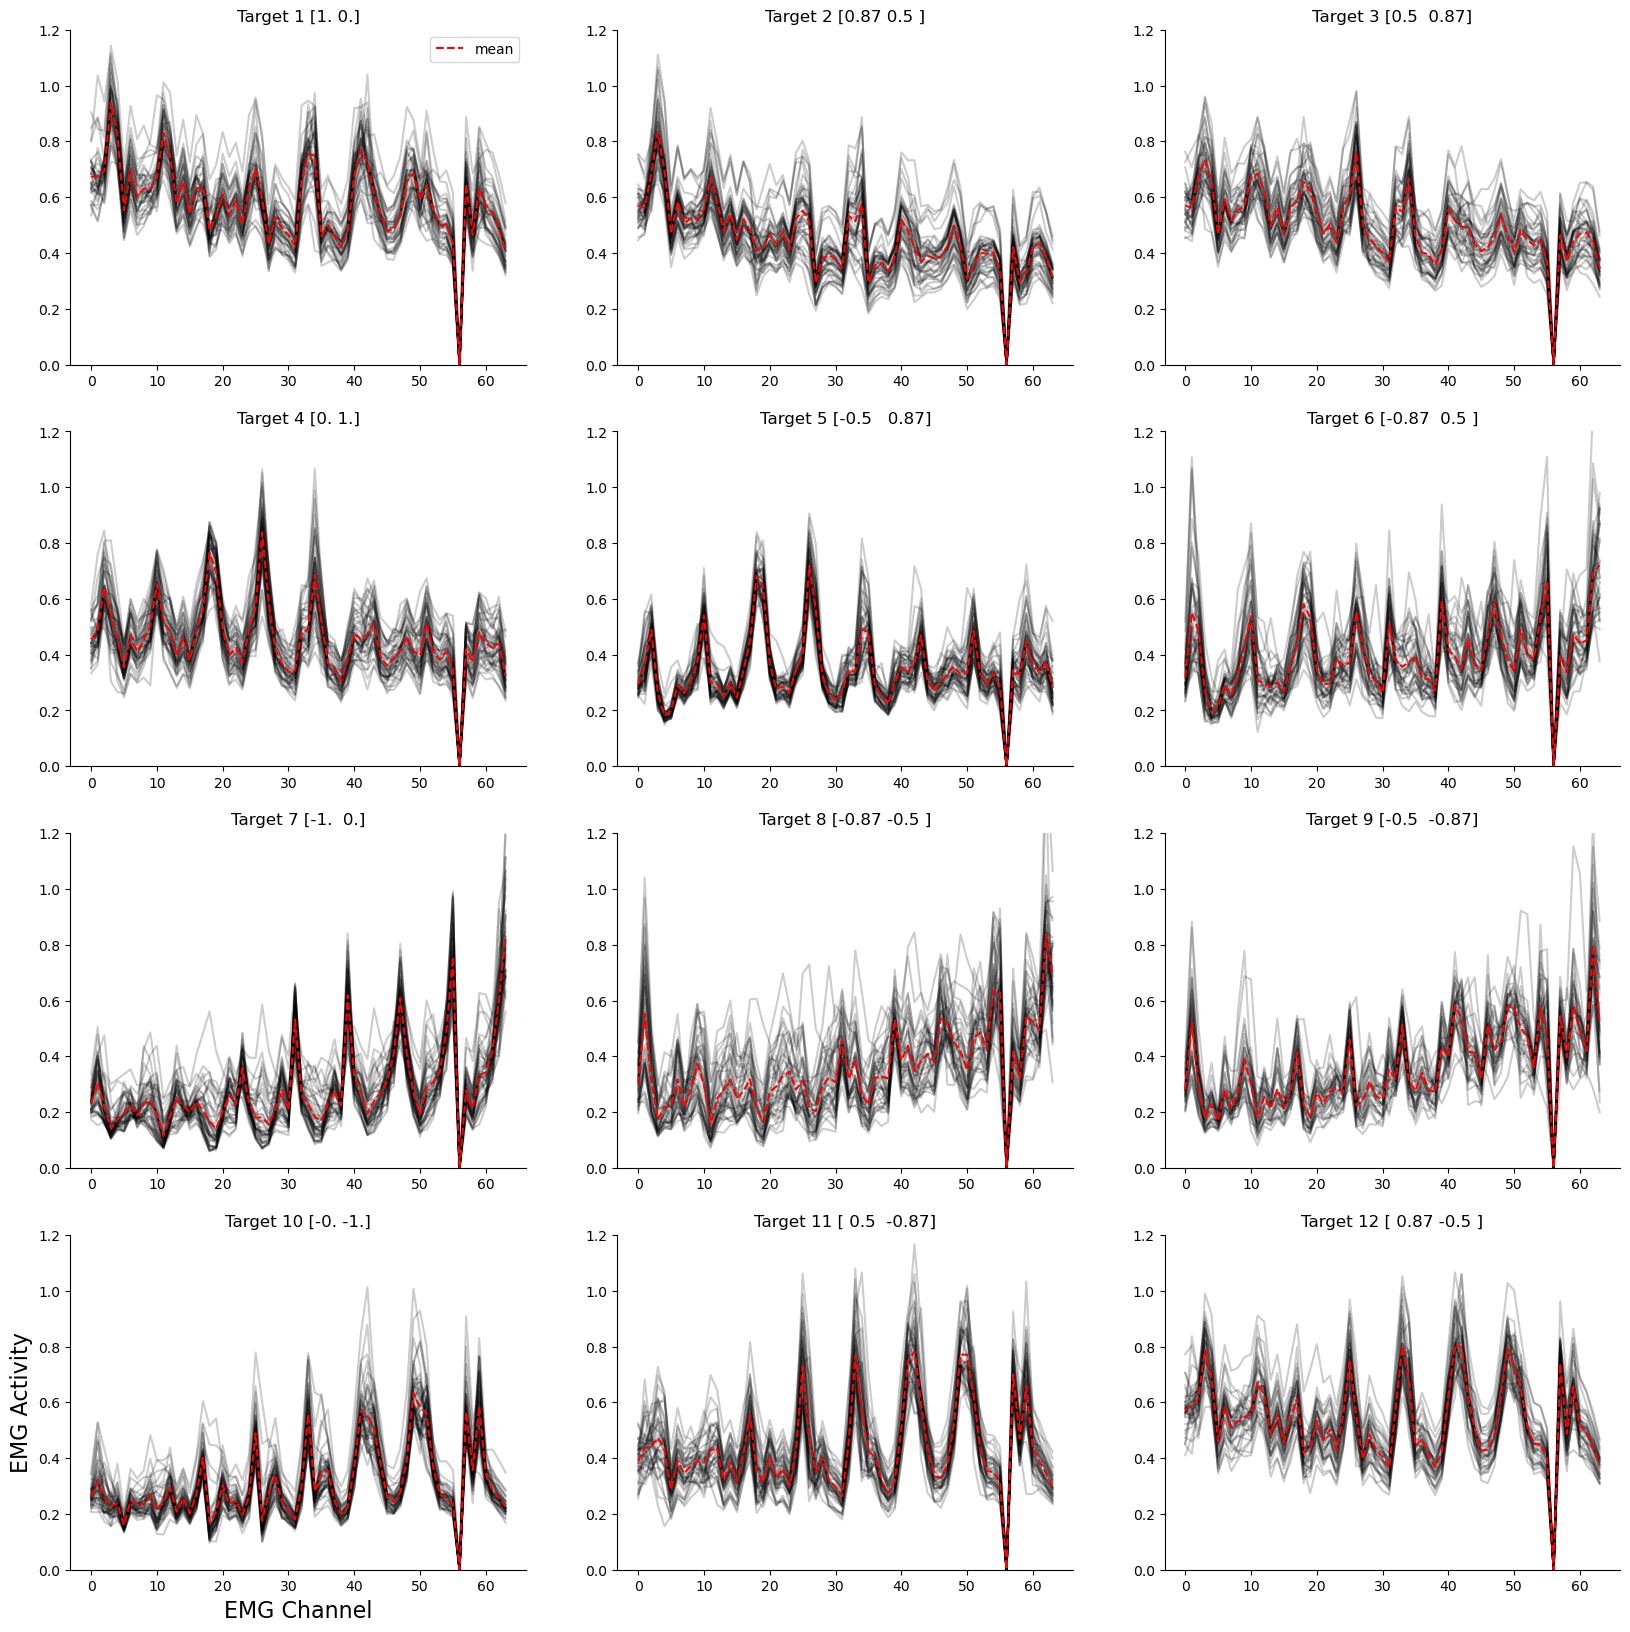

In [18]:
example_hit_ends, axes = plt.subplots(4,3,figsize=(20,20))
axes = axes.ravel()

subject_idx = 6

movement_model = model.load_log_movement_models(subject_idx)[0]
calibration_model = model.load_log_calibration_models(subject_idx)[0]

movement_model_mean = np.mean([model.make_lognormal_mean(m.reshape(-1,1),c).reshape(-1) for m,c in zip(movement_model.means_, movement_model.covariances_)],axis=0)
calibration_model_mean = np.mean([model.make_lognormal_mean(m.reshape(-1,1),c).reshape(-1) for m,c in zip(calibration_model.means_, calibration_model.covariances_)],axis=0)

movement_data_mean = compute_movement_mean(subject_idx)
calibration_data_mean = compute_calibration_mean(subject_idx)

for target_idx in range(12):
    # axes[target_idx].plot(calibration_data_mean,"--",alpha=0.5,zorder=100,label="Calibration Data Mean")
    # axes[target_idx].plot(calibration_model_mean,"--",alpha=0.5,zorder=100,label="Calibration Model Mean")
    # axes[target_idx].plot(movement_data_mean,"--",alpha=0.5,zorder=100,label="Movement Data Mean")
    # axes[target_idx].plot(movement_model_mean,"--",alpha=0.5,zorder=100,label="Movement Model Mean")
    subject_target_ends = analysis.remove_nan_rows(hit_ends[subject_idx,:,target_idx])
    for end in subject_target_ends:
        axes[target_idx].plot(end,"k",alpha=0.2,linestyle="-",marker="")
    axes[target_idx].plot(hit_end_means[subject_idx,target_idx],"r--",label="mean")
    axes[target_idx].set_title(f"Target {target_idx+1} {collection.compute_target_vec_from_number(target_idx+1)}")
    axes[target_idx].set_ylim([0,1.2])
axes[0].legend()
axes[9].set_xlabel("EMG Channel")
axes[9].set_ylabel("EMG Activity")

In [19]:
plot.save_figure(example_hit_ends,"example_hit_ends",image_path)

Figure saved to /Users/spencer/phd/phd/images/more_results/nullspace/example_hit_ends.pdf


# compute solutions

In [10]:
# check if subject's channel 56 is dead
tol = 1e-7
for subject_idx in range(46):
    for target_idx in range(12):
        mean56 = np.mean(analysis.remove_nan_rows(hit_ends[subject_idx,:,target_idx])[:,56])
        if not np.isclose(mean56, 0, rtol=tol):
            print(subject_idx, target_idx, mean56)

In [11]:
from analysis.model import *

In [12]:
import warnings
warnings.filterwarnings("ignore", message="Values in x were outside bounds during a minimize step, clipping to bounds")

In [13]:
# subject, solution type, target, channel
computed_solutions = np.zeros(shape=(46,7,12,64))
computed_solutions[:] = np.nan
for subject_idx in range(len(subjects)):
    decoder = subjects[subject_idx].decoder[-2:,:]
    movement_cov = compute_movement_cov(subject_idx)
    movement_mean = compute_movement_mean(subject_idx)
    calibration_mean = compute_calibration_mean(subject_idx)
    calibration_cov = compute_calibration_cov(subject_idx)
    print(f"subject {subject_idx}")
    calibration_model = load_log_calibration_models(subject_idx)[0]
    movement_model = load_log_movement_models(subject_idx)[0]
    for target_idx in range(12):
        target_vec = collection.compute_target_vec_from_number(target_idx+1)
        # the "pinv" solution
        computed_solutions[subject_idx,0,target_idx] = lagrange_fit(np.eye(64),np.zeros(shape=(64,1)),decoder,target_vec.reshape(-1),nonnegative=True)

        # movement mean error
        computed_solutions[subject_idx,1,target_idx] = lagrange_fit(np.eye(64),movement_mean,decoder,target_vec.reshape(-1),nonnegative=True)

        # calibration mean error
        computed_solutions[subject_idx,2,target_idx] = lagrange_fit(np.eye(64),calibration_mean,decoder,target_vec.reshape(-1),nonnegative=True)

        # the "gaussian" likelihood with movement stats solution
        computed_solutions[subject_idx,3,target_idx] = lagrange_fit(np.linalg.inv(movement_cov),movement_mean,decoder,target_vec.reshape(-1),nonnegative=True)

        # the "gaussian" likelihood with calibration stats
        computed_solutions[subject_idx,4,target_idx] = lagrange_fit(np.linalg.inv(calibration_cov),calibration_mean,decoder,target_vec.reshape(-1),nonnegative=True)

        # the movement mixture likelihood solution nonnegative -- starting from gaussian solution
        computed_solutions[subject_idx,5,target_idx] = lagrange_fit_model(movement_model,decoder,target_vec.reshape(-1),e0=computed_solutions[subject_idx,3,target_idx],nonnegative=True)

        # the calibration mixture likelihood solution nonnegative -- starting from gaussian solution
        computed_solutions[subject_idx,6,target_idx] = lagrange_fit_model(calibration_model,decoder,target_vec.reshape(-1),e0=computed_solutions[subject_idx,4,target_idx],nonnegative=True)


subject 0
subject 1
subject 2
subject 3
subject 4
subject 5
subject 6
subject 7
subject 8
subject 9
subject 10
subject 11
subject 12
subject 13
subject 14
subject 15
subject 16
subject 17
subject 18
subject 19
subject 20
subject 21
subject 22
subject 23
subject 24
subject 25
subject 26
subject 27
subject 28
subject 29
subject 30
subject 31
subject 32
subject 33
subject 34
subject 35
subject 36
subject 37
subject 38
subject 39
subject 40
subject 41
subject 42
subject 43
subject 44
subject 45


In [52]:
labels = ["Standard Normal", 
          "Movement Mean",
          "Calibration Mean",
          "Movement Normal",
          "Calibration Normal",
          "Movement GMM Likelihood",
          "Calibration GMM Likelihood"]

In [17]:
# with open('../../computed_solutions.pkl', 'wb') as handle:
#     pickle.dump(computed_solutions, handle)

In [6]:
with open('../computed_solutions.pkl', 'rb') as handle:
    computed_solutions = pickle.load(handle)
print(computed_solutions.shape)

EOFError: Ran out of input

## computed solutions for a single subject

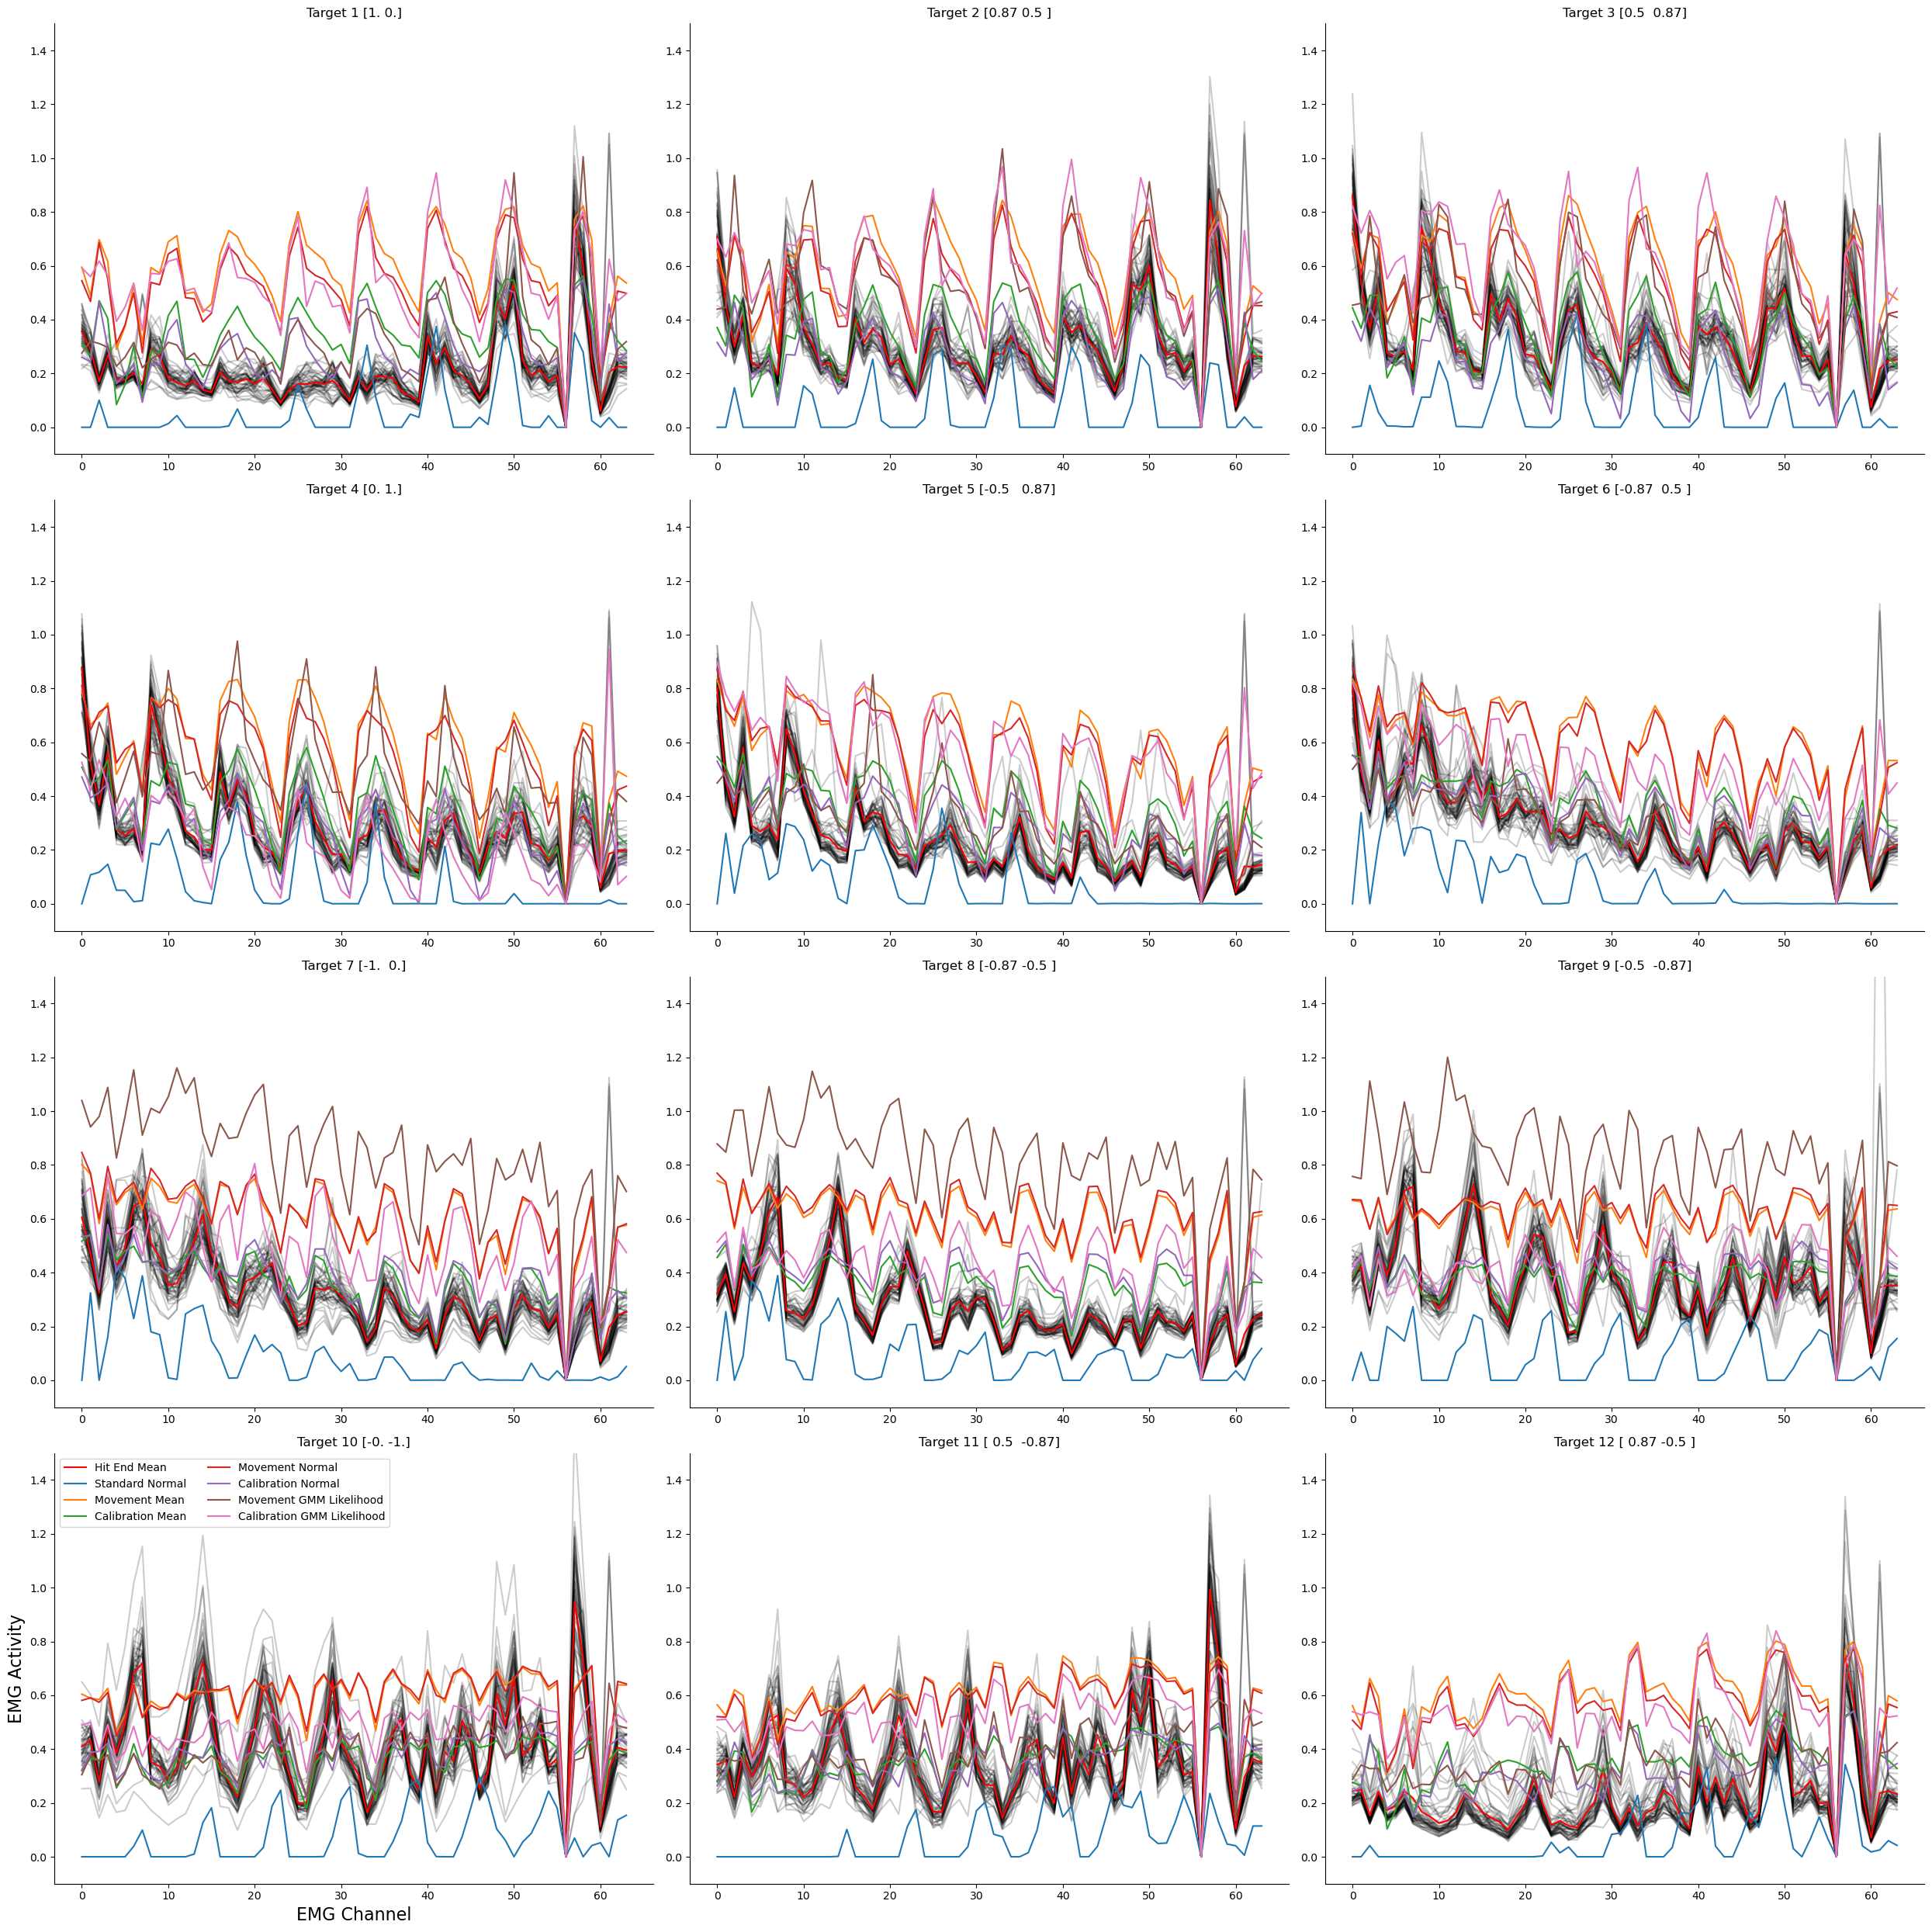

In [58]:
computed_solutions_fig, axes = plt.subplots(4,3,figsize=(25,25))
axes = axes.ravel()
         
subject_idx = 29
                          
for target_idx in range(12):

    subject_target_ends = analysis.remove_nan_rows(hit_ends[subject_idx,:,target_idx])

    # plot hit ends and their mean
    for end in subject_target_ends:
        h, = axes[target_idx].plot(end,"k-",alpha=0.2)
    h.set_label = "Hit End Data"
    axes[target_idx].plot(hit_end_means[subject_idx,target_idx],"r-",label="Hit End Mean")

    for i in range(7):
        axes[target_idx].plot(computed_solutions[subject_idx,i,target_idx],"-",label=labels[i])
    
    axes[target_idx].set_title(f"Target {target_idx+1} {collection.compute_target_vec_from_number(target_idx+1)}")
    axes[target_idx].set_ylim([-0.1,1.5])

axes.reshape(4,3)[3,0].set_xlabel("EMG Channel")
axes.reshape(4,3)[3,0].set_ylabel("EMG Activity")
axes.reshape(4,3)[3,0].legend(ncol=2)
computed_solutions_fig.tight_layout()

# plt.figure()
# for subject_idx, subject in enumerate(subjects):
#     for i in range(computed_solutions.shape[1]):
#         vec = subject.decoder[-2:,:] @ computed_solutions[subject_idx,i].T
#         plt.plot(vec[0],vec[1],'o',label=labels[i],alpha=0.2)

#     for ti in range(1,13):
#         vec = collection.compute_target_vec_from_number(ti)
#         plt.plot([0,vec[0]],[0,vec[1]],'k-',alpha=0.2)

# plot.plot_targets(plt.gca())

In [59]:
plot.save_figure(computed_solutions_fig, "example_computed_solutions", image_path)

Figure saved to /Users/spencer/phd/phd/images/more_results/nullspace/example_computed_solutions.pdf


### look at mean null and task space activities for different solutions

In [30]:
# d = subjects[0].decoder[-2:,:]
# task, null = analysis.compute_subspaces(d)
# for i in range(12):
#     for s in computed_solutions[0,:,i]:
#         s = s.reshape(-1,1)
#         t = collection.compute_target_vec_from_number(i+1)
#         print(f"task: {np.mean(task @ s)} | null: {np.mean(null @ s)} | target error: {np.linalg.norm(d @ s - t)}")
#     print(" ")

In [40]:
from scipy.spatial import distance

# subject, solution type, trial, target
# diffs = np.zeros(shape=(46,10,45,12))
# diffs[:] = np.nan
cosines = np.zeros(shape=(46,7,45,12))
cosines[:] = np.nan
for subject_idx, subject in enumerate(subjects):
    for target_idx in range(12):
        subject_target_ends = analysis.remove_nan_rows(hit_ends[subject_idx,:,target_idx])
        for solution_idx, solution in enumerate(computed_solutions[subject_idx,:,target_idx]):
            for hit_end_idx, hit_end in enumerate(subject_target_ends):
                # diffs[subject_idx,solution_idx,hit_end_idx,target_idx] = np.linalg.norm(hit_end - solution)**2 / (np.linalg.norm(hit_end)*np.linalg.norm(solution))
                # dont hold the dead channel against them
                solution[56] = 0
                # 0 is identical, 1 is orthogonal
                cosines[subject_idx,solution_idx,hit_end_idx,target_idx] = distance.cosine(hit_end,solution)

[0, 1, 2, 3, 4, 5, 6]


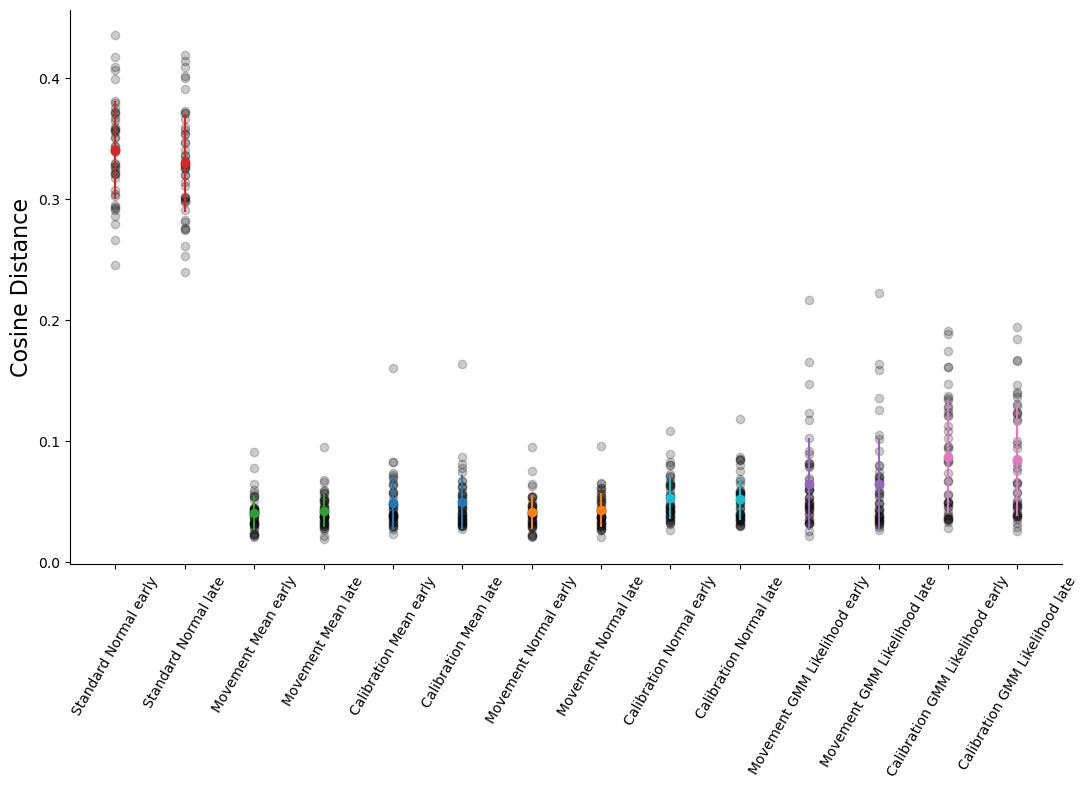

In [61]:
# this is subjects, solutions, early/late/both -- the mean for each solution and subject
# mean_diffs = np.zeros(shape=(46,10,3))
# mean_diffs[:] = np.nan

# subjects, solutions, first/second/all
mean_cosines = np.zeros(shape=(46,7,3))
mean_cosines[:] = np.nan

for subject_idx in range(len(subjects)):
    for solution_idx in range(7):
        # all the solution diffs of this solution type
        # this reshape yields target1.trial1, target2.trial2, etc. -- in trial order
        # solution_diffs = analysis.remove_nan_rows(diffs[subject_idx, solution_idx].reshape(-1,1))
        solution_cosines = analysis.remove_nan_rows(cosines[subject_idx, solution_idx].reshape(-1,1))
        # assert mean_diffs.shape == mean_cosines.shape
        num_hits = solution_cosines.shape[0]
        # now i need for each solution, split into early and late, subject means
        # early
        # mean_diffs[subject_idx,solution_idx,0] = np.mean(solution_diffs[:num_hits//2])
        mean_cosines[subject_idx,solution_idx,0] = np.mean(solution_cosines[:num_hits//2])
        # late
        # mean_diffs[subject_idx,solution_idx,1] = np.mean(solution_diffs[num_hits//2:])
        mean_cosines[subject_idx,solution_idx,1] = np.mean(solution_cosines[num_hits//2:])
        # both
        # mean_diffs[subject_idx,solution_idx,2] = np.mean(solution_diffs)
        mean_cosines[subject_idx,solution_idx,2] = np.mean(solution_cosines)

# early and late separate to see if there's any shift
def plot_early_late_subjects_and_means(data,data_idxs,ylabel,ax=None):
    print(data_idxs)
    # data axes are: subjects, conditions, value
    if ax is None:
        fig, ax = plt.subplots(1,1)
    ax.set_ylabel(ylabel)
    ones = np.ones(shape=(len(subjects)))
    ticks = []
    tick_labels = []
    colors = ["tab:red","tab:green","tab:blue","tab:orange","tab:cyan","tab:purple","tab:pink",]
    for i in data_idxs:
        ax.plot(ones*i,data[:,i,0],"ko",alpha=0.2)
        ax.plot(ones*(i+0.5),data[:,i,1],"ko",alpha=0.2)
        h = ax.errorbar(x=i,y=np.mean(data[:,i,0]),yerr=np.std(data[:,i,0]),color=colors[i],fmt="o")
        ax.errorbar(x=(i+0.5),y=np.mean(data[:,i,1]),yerr=np.std(data[:,i,0]),color=colors[i],fmt="o")
        ticks += [i, i+0.5]
        tick_labels += [labels[i] + " early", labels[i] + " late"]
        # stats = sp.stats.ttest_ind(data[:,i,0],data[:,i,1],equal_var=False)
        # print(f"early - late ({labels[i]}) p value: ",stats.pvalue*100,"%")
    ax.set_xticks(ticks=ticks, labels=tick_labels, rotation=60)
    return fig, ax

# # early and late combined
# fig, ax = plt.subplots(1,1)
# ax.set_ylabel("cosine distance")
# ones = np.ones(shape=(len(subjects)))
# ticks = []
# tick_labels = []
# for i in range(7):
#     ax.plot(ones*i,mean_cosines[:,i,0],"ko",alpha=0.2)
#     ax.errorbar(x=i,y=np.mean(mean_cosines[:,i,0]),yerr=np.std(mean_cosines[:,i,0]),color="r",fmt="o")
#     ticks += [i]
#     tick_labels += [labels[i]]
# ax.set_xticks(ticks=ticks, labels=tick_labels, rotation=45)

# nonnegative solutions, euclidean distances
# plot_early_late_subjects_and_means(mean_diffs,data_idxs=list(range(1,10,2)),ylabel="euclidean distance")
# nonnegative solutions, cosine distances
cosine_fig, ax = plot_early_late_subjects_and_means(mean_cosines,data_idxs=list(range(7)),ylabel="Cosine Distance")

# stats = sp.stats.ttest_ind(mean_cosines[:,1,2],mean_cosines[:,3,2],equal_var=False)
# print("unweighted - prior_mean p value: ",stats.pvalue*100,"%")

# stats = sp.stats.ttest_ind(mean_cosines[:,1,2],mean_cosines[:,5,2],equal_var=False)
# print("unweighted - prior_weighted p value: ",stats.pvalue*100,"%")

# stats = sp.stats.ttest_ind(mean_cosines[:,1,2],mean_cosines[:,7,2],equal_var=False)
# print("unweighted - mixture_likelihood p value: ",stats.pvalue*100,"%")

# stats = sp.stats.ttest_ind(mean_cosines[:,3,2],mean_cosines[:,5,2],equal_var=False)
# print("prior_mean - prior_weighted p value: ",stats.pvalue*100,"%")

# stats = sp.stats.ttest_ind(mean_cosines[:,3,2],mean_cosines[:,7,2],equal_var=False)
# print("prior_mean - mixture_likelihood p value: ",stats.pvalue*100,"%")

# stats = sp.stats.ttest_ind(mean_cosines[:,5,2],mean_cosines[:,7,2],equal_var=False)
# print("prior_weighted - mixture_likelihood p value: ",stats.pvalue*100,"%")

In [62]:
plot.save_figure(cosine_fig, "cosine_distance_solutions", image_path)

Figure saved to /Users/spencer/phd/phd/images/more_results/nullspace/cosine_distance_solutions.pdf


<Figure size 1280x720 with 0 Axes>

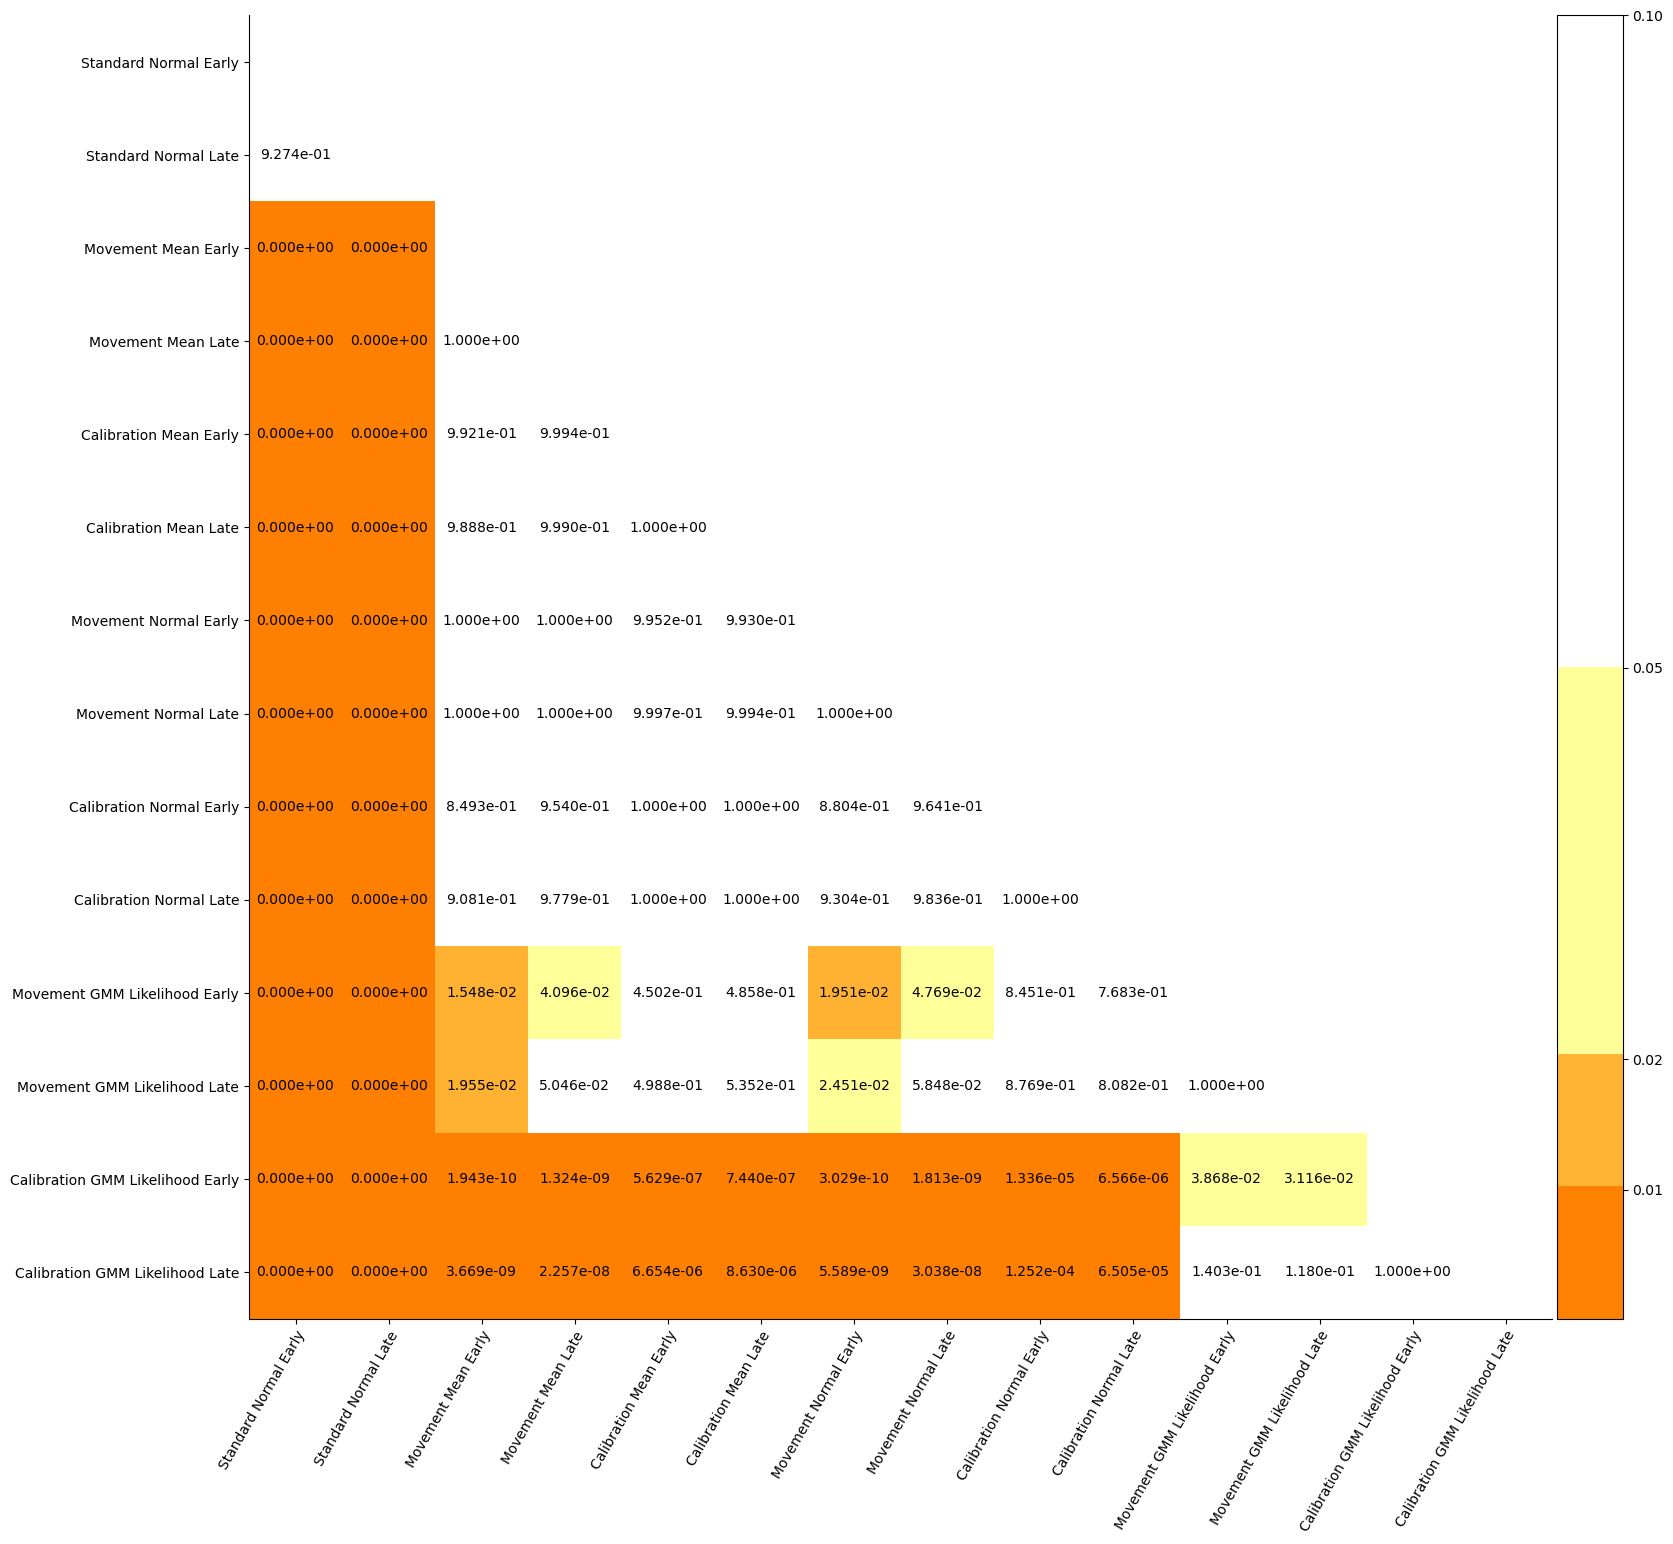

In [65]:
from scipy import stats
pvalue_fig = plt.figure()
heatmap_labels = np.array([[l1 + " Early", l2 + " Late"] for l1, l2 in zip(labels, labels)]).flatten()
result = stats.tukey_hsd(*mean_cosines[:,:,:2].reshape(46,14).T)
pvalue_fig, (ax,cax) = plot.annotated_heatmap(result.pvalue,heatmap_labels,heatmap_labels)
pvalue_fig.set_size_inches(20,20)

In [66]:
plot.save_figure(pvalue_fig, "optimization_pvalues", image_path,forma="png")

Figure saved to /Users/spencer/phd/phd/images/more_results/nullspace/optimization_pvalues.pdf


# zoom in over trial chunks -- only look at calibration

no difference...

(46, 7, 45, 12)
(4968,)


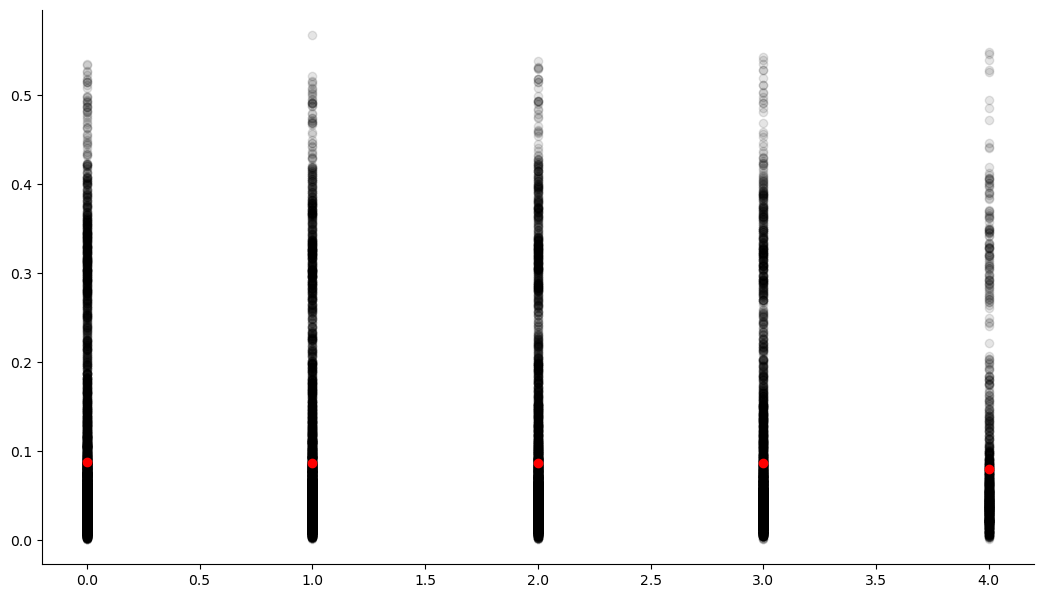

In [87]:
print(cosines.shape)
print(cosines[:,-1,idx[0]:idx[1],:].reshape(-1).shape)

chunk_indices = analysis.make_chunk_indices()

for i, idx in enumerate(chunk_indices):
    c = cosines[:,-1,idx[0]:idx[1],:].reshape(-1)
    plt.plot(np.ones(shape=c.shape)*i, c, "ko",alpha=0.1)
    plt.plot(i,np.nanmean(c),"ro")

# what about only best performing subjects?

We don't see a difference... 

In [68]:
with open("../trajectory_dataframe.pkl",'rb') as handle:
    trajectory_df = pd.read_pickle(handle)
# make sure to invert this -- it's distance to the target
reward = np.array(trajectory_df.groupby("subject").mean()["reward"])**-1

top_subjects = np.argsort(reward)[::-1][:20]
reward.shape, reward[top_subjects], top_subjects

((46,),
 array([1.9326813 , 1.54314971, 1.41542515, 1.36857127, 1.36799368,
        1.35118562, 1.31001466, 1.27098927, 1.26735065, 1.227908  ,
        1.21594179, 1.21541202, 1.19674365, 1.19303132, 1.19082301,
        1.15561574, 1.148271  , 1.14524881, 1.10346265, 1.09575687]),
 array([29,  6, 37, 11,  0, 16, 22, 35, 36, 17, 33, 32, 15, 24,  3, 41, 14,
        21, 40, 18]))

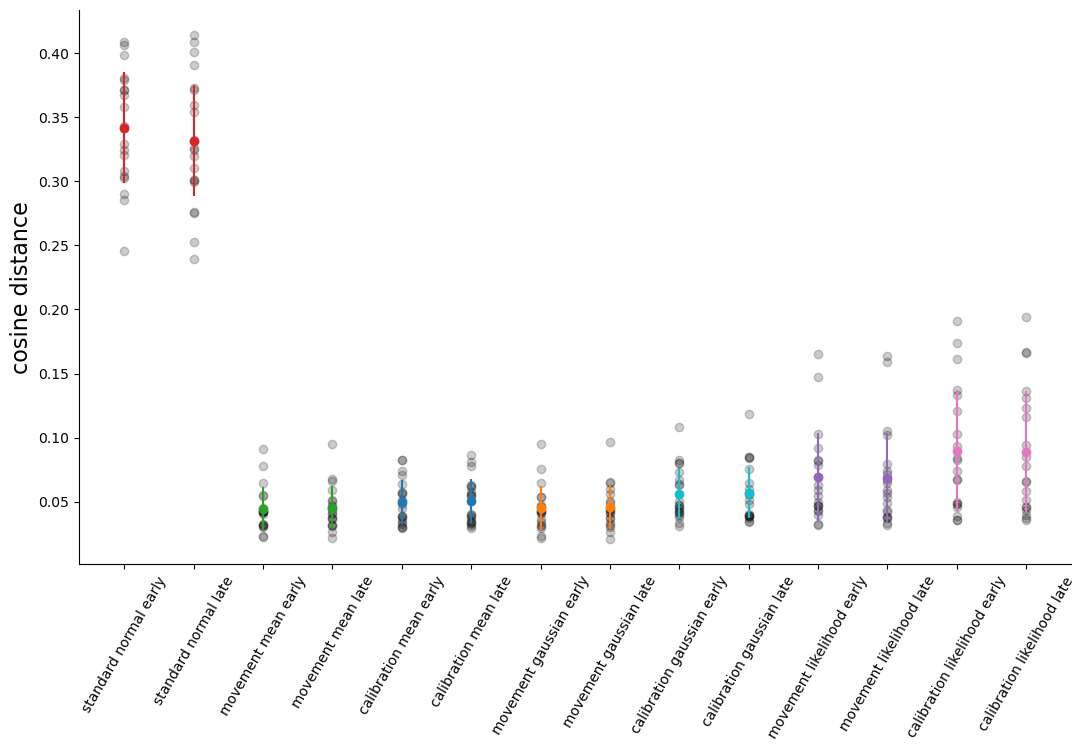

In [91]:
# this is subjects, solutions, early/late/both -- the mean for each solution and subject
# mean_diffs = np.zeros(shape=(46,10,3))
# mean_diffs[:] = np.nan

# subjects, solutions, first/second/all
mean_cosines = np.zeros(shape=(46,7,3))
mean_cosines[:] = np.nan

for subject_idx in top_subjects:
    for solution_idx in range(7):
        # all the solution diffs of this solution type
        # this reshape yields target1.trial1, target2.trial2, etc. -- in trial order
        # solution_diffs = analysis.remove_nan_rows(diffs[subject_idx, solution_idx].reshape(-1,1))
        solution_cosines = analysis.remove_nan_rows(cosines[subject_idx, solution_idx].reshape(-1,1))
        # assert mean_diffs.shape == mean_cosines.shape
        num_hits = solution_cosines.shape[0]
        # now i need for each solution, split into early and late, subject means
        # early
        # mean_diffs[subject_idx,solution_idx,0] = np.mean(solution_diffs[:num_hits//2])
        mean_cosines[subject_idx,solution_idx,0] = np.mean(solution_cosines[:num_hits//2])
        # late
        # mean_diffs[subject_idx,solution_idx,1] = np.mean(solution_diffs[num_hits//2:])
        mean_cosines[subject_idx,solution_idx,1] = np.mean(solution_cosines[num_hits//2:])
        # both
        # mean_diffs[subject_idx,solution_idx,2] = np.mean(solution_diffs)
        mean_cosines[subject_idx,solution_idx,2] = np.mean(solution_cosines)

# early and late separate to see if there's any shift
def plot_early_late_subjects_and_means(data,data_idxs,ylabel,ax=None):
    # data axes are: subjects, conditions, value
    if ax is None:
        fig, ax = plt.subplots(1,1)
    ax.set_ylabel(ylabel)
    ones = np.ones(shape=(len(top_subjects)))
    ticks = []
    tick_labels = []
    colors = ["tab:red","tab:green","tab:blue","tab:orange","tab:cyan","tab:purple","tab:pink",]
    for i in data_idxs:
        ax.plot(ones*i,data[top_subjects,i,0],"ko",alpha=0.2)
        ax.plot(ones*(i+0.5),data[top_subjects,i,1],"ko",alpha=0.2)
        h = ax.errorbar(x=i,y=np.mean(data[top_subjects,i,0]),yerr=np.std(data[top_subjects,i,0]),color=colors[i],fmt="o")
        ax.errorbar(x=(i+0.5),y=np.mean(data[top_subjects,i,1]),yerr=np.std(data[top_subjects,i,0]),color=colors[i],fmt="o")
        ticks += [i, i+0.5]
        tick_labels += [labels[i] + " early", labels[i] + " late"]
        # stats = sp.stats.ttest_ind(data[top_subjects,i,0],data[top_subjects,i,1],equal_var=False)
        # print(f"early - late ({labels[i]}) p value: ",stats.pvalue*100,"%")
    ax.set_xticks(ticks=ticks, labels=tick_labels, rotation=60)

# # early and late combined
# fig, ax = plt.subplots(1,1)
# ax.set_ylabel("cosine distance")
# ones = np.ones(shape=(len(subjects)))
# ticks = []
# tick_labels = []
# for i in range(7):
#     ax.plot(ones*i,mean_cosines[:,i,0],"ko",alpha=0.2)
#     ax.errorbar(x=i,y=np.mean(mean_cosines[:,i,0]),yerr=np.std(mean_cosines[:,i,0]),color="r",fmt="o")
#     ticks += [i]
#     tick_labels += [labels[i]]
# ax.set_xticks(ticks=ticks, labels=tick_labels, rotation=45)

# nonnegative solutions, euclidean distances
# plot_early_late_subjects_and_means(mean_diffs,data_idxs=list(range(1,10,2)),ylabel="euclidean distance")
# nonnegative solutions, cosine distances
plot_early_late_subjects_and_means(mean_cosines,data_idxs=list(range(7)),ylabel="cosine distance")

# stats = sp.stats.ttest_ind(mean_cosines[:,1,2],mean_cosines[:,3,2],equal_var=False)
# print("unweighted - prior_mean p value: ",stats.pvalue*100,"%")

# stats = sp.stats.ttest_ind(mean_cosines[:,1,2],mean_cosines[:,5,2],equal_var=False)
# print("unweighted - prior_weighted p value: ",stats.pvalue*100,"%")

# stats = sp.stats.ttest_ind(mean_cosines[:,1,2],mean_cosines[:,7,2],equal_var=False)
# print("unweighted - mixture_likelihood p value: ",stats.pvalue*100,"%")

# stats = sp.stats.ttest_ind(mean_cosines[:,3,2],mean_cosines[:,5,2],equal_var=False)
# print("prior_mean - prior_weighted p value: ",stats.pvalue*100,"%")

# stats = sp.stats.ttest_ind(mean_cosines[:,3,2],mean_cosines[:,7,2],equal_var=False)
# print("prior_mean - mixture_likelihood p value: ",stats.pvalue*100,"%")

# stats = sp.stats.ttest_ind(mean_cosines[:,5,2],mean_cosines[:,7,2],equal_var=False)
# print("prior_weighted - mixture_likelihood p value: ",stats.pvalue*100,"%")